In [ ]:
import ee 

email = "my-service-account@...gserviceaccount.com"
key_file = "/path-to-key/key-file.json"

# Authenticate and initialize
credentials = ee.ServiceAccountCredentials(email=email, key_file=key_file)
ee.Initialize(credentials)

In [8]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from shapely.wkt import loads
from tobler.util import h3fy
import folium

## Create Hexagonal H3 Grid for the US Region

In [3]:
# GET THE US BOUNDARY USING BIG QUERY PUBLIC DATA
query = """SELECT * FROM `bigquery-public-data.geo_us_boundaries.national_outline`"""
conus = pd.read_gbq(query)

conus = conus.iloc[:, 0].apply(loads) #get the geometric object from string
conus = gpd.GeoDataFrame(conus, geometry=conus.name, crs='epsg:4326') #convert conus to a geodataframe

In [ ]:
# CREATE HEXAGONAL H3 GRID FOR THE US REGION
hexgrid_us = h3fy(conus.buffer(0.01), resolution=4).reset_index()

In [6]:
# SELECT ROWS WITH LATITUDES (20 to 60) AND LONGITUDES (-130 to -65)

hexgrid_us['longitude'] = hexgrid_us['geometry'].apply(lambda x: x.centroid.coords.xy[0][0])
hexgrid_us['latitude'] = hexgrid_us['geometry'].apply(lambda x: x.centroid.coords.xy[1][0])
hexgrid_us = hexgrid_us[(hexgrid_us['longitude'].between(-130, -65)) & (hexgrid_us['latitude'].between(20, 60))][['hex_id', 'geometry']]

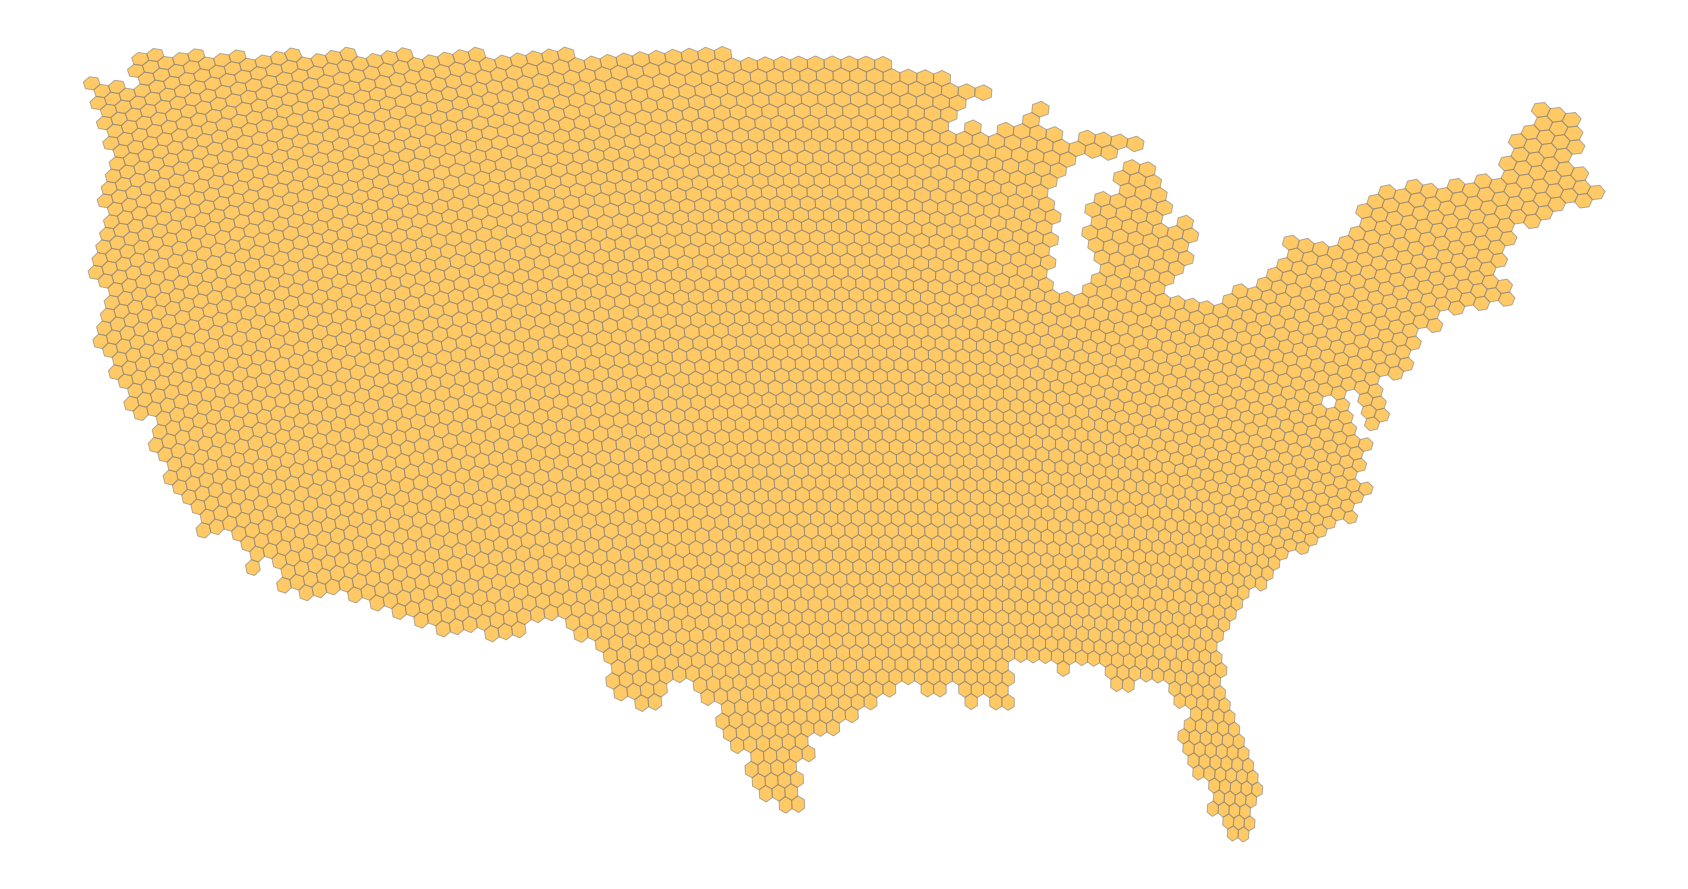

In [7]:
# PLOT THE GEODATAFRAME
fig, ax = plt.subplots(figsize=(30, 26))

hexgrid_us.plot(ax=ax, color='orange', edgecolor='grey', alpha=0.6)
ax.set_axis_off()

## Calculate Zonal Statistics Using Earth Engine

In [10]:
# Create an earth engine feature from a shapely geometry
def get_ee_feature(geom):
    x,y = geom.exterior.coords.xy
    coords = np.dstack((x,y)).tolist()
    g = ee.Geometry.Polygon(coords)
    return ee.Feature(g)

features = ee.FeatureCollection([get_ee_feature(x[1].geometry) for x in hexgrid_us.iterrows()])

# Create a single image from image collection and select the band you are interested in
image_collection = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY")
image = image_collection.filterDate('2015-01-01', '2021-12-31').select('temperature_2m').mean()

# Calculate zonal statistics
zone_stats = image.reduceRegions(collection=features, reducer=ee.Reducer.mean(), scale=11132, tileScale=1).getInfo()
zone_stats = gpd.GeoDataFrame.from_features(zone_stats, crs='epsg:4326')

## Plot the Zonal Statistics Data

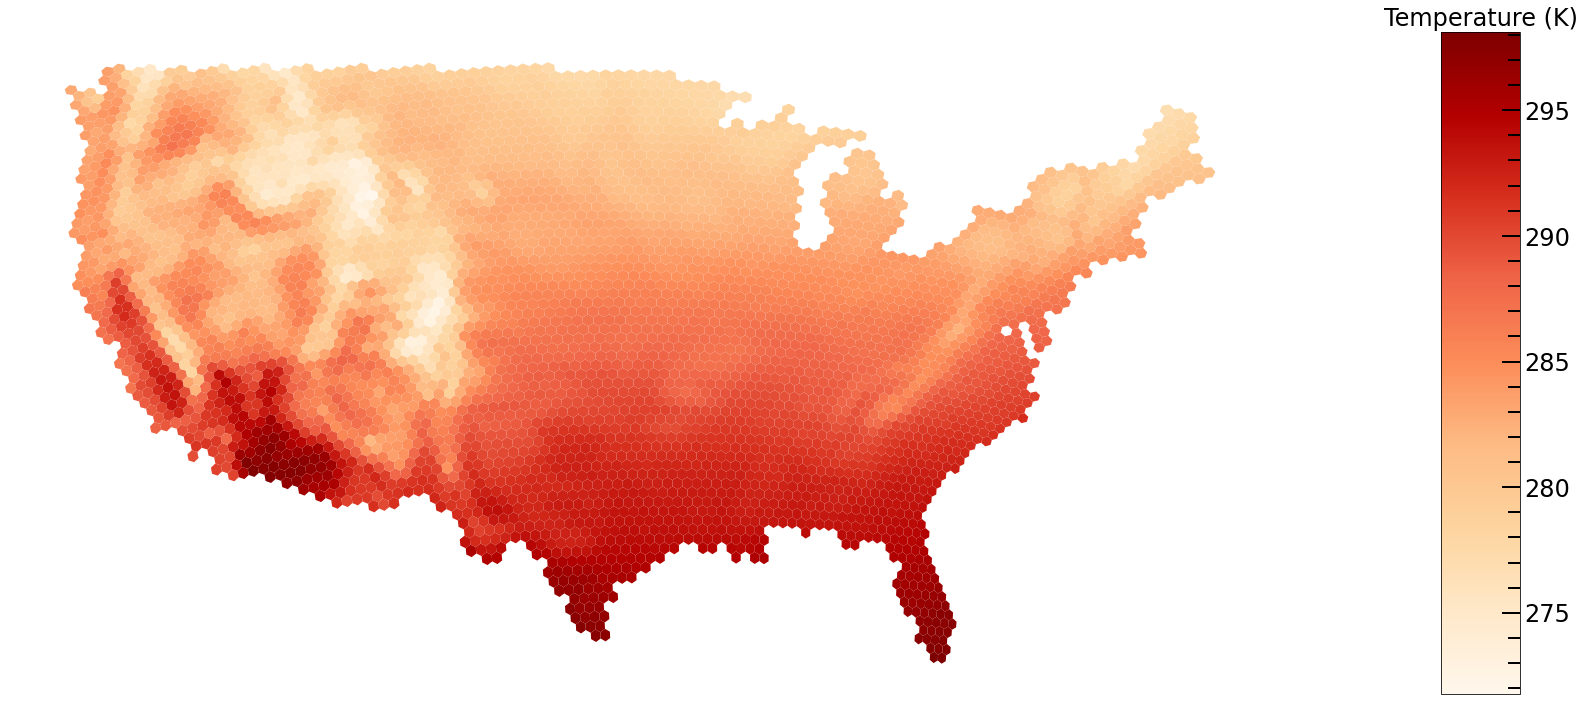

In [12]:
fig, ax= plt.subplots(figsize=(30,26))

# Define the legend axes
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Plot the US map with hexagons where the colour of each hexagon represents the mean air temperature value
zone_stats.plot(column='mean', ax=ax, cmap='OrRd', legend=True, cax=cax)

# Customise the legend
cax.minorticks_on()
cax.tick_params(which='major', direction='in', length=18, width=2, labelsize=24)
cax.tick_params(which='minor', direction='in', length=12, width=2, labelsize=24)
cax.set_title('Temperature (K)', fontsize=24)

# Turn the x-axis and y-axis off
ax.set_axis_off()

## Create an Interactive Map

In [20]:
temp_map = zone_stats.explore(column='mean', name='Mean Temperature', cmap='OrRd', 
                              style_kwds={'opacity':0.4, 'color':'black', 'opacity':0.2}, 
                              highlight_kwds={'fillOpacity':1}, 
                              tooltip_kwds={'aliases':['Temperature']}, 
                              legend_kwds={'caption':'Mean Temperature (K)'})

# Add layer control to the map
folium.TileLayer('cartodbdark_matter',overlay=True,name="View in Dark Mode").add_to(temp_map)
folium.TileLayer('cartodbpositron',overlay=True,name="Viw in Light Mode").add_to(temp_map)
folium.LayerControl(collapsed=False).add_to(temp_map)

temp_map